
<p style="text-align:center;">
    <span style="text-decoration:underline; font-weight:bold; font-size:24px;">
        Implementing Shrinkage Risk Parity and Hierarchical Risk Parity Portfolio Models Utilizing Noise Reduction and Machine Learning Techniques
    </span>
</p>





Date : June 2023


## Abstract

Accurate prediction of asset price movements is crucial for effective trading strategies. This project explores the implementation of two versions of Risk Parity portfolios using advanced noise reduction and machine learning techniques. The focus is on comparing the performance of the Shrinkaged Risk Parity Model and the Hierarchical Risk Parity Model, utilizing the Python packages such as yfinance and Riskfolio-Lib for data acquisition and model development. The models' performances are evaluated through extensive back-testing on historical ETF data. The objective is to optimize asset allocation based on risk contributions, aiming to enhance portfolio returns and examining the impact of noise reduction methods on the accuracy and stability of the portfolios.

### 1. Install and Import Package

In [95]:
# package : yfinance, Riskfolio-lib
!pip install yfinance --quiet
!pip install Riskfolio-lib --quiet

In [96]:
# import package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import minimize
import yfinance as yf
from sklearn.covariance import LedoitWolf
import riskfolio as rp

References

  - LedoitWolf: https://scikit-learn.org/stable/modules/generated/sklearn.covariance.LedoitWolf.html  - 
Riskfolio-Lib: https://riskfolio-lib.readthedocs.io/en/latest/

### 2. Generating ETF Data Collection and Return Rate

Ticker List: ['SPY', 'FEZ', 'EWJ', 'EEM', 'IEF', 'TLT', 'TIP', 'GLD', 'DBC', 'DBA', 'IYR']

- Price Data Start Date: Jan 1, 2005
- Price Data End Date: May 31, 2024
- Steps:

1. Collect the price data for the given ETFs within the specified date range.
2. Resample the price data on a weekly basis.
3. Use the closing prices for backtesting.

In [97]:
def get_etf_price_data(tickers):
    etf = yf.Tickers(tickers)
    data = etf.history(start='2005-01-01', end='2024-05-31', actions=False)
    data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
    data = data.droplevel(0, axis=1)
    data.ffill(inplace=True)
    df = data.resample('W').last()
    return df

In [98]:
# Price Data
tickers = ['SPY', 'FEZ', 'EWJ', 'EEM', 'IEF', 'TLT', 'TIP', 'GLD', 'DBC', 'DBA', 'IYR']
df = get_etf_price_data(tickers)

# weekly return rates data
rets=df.pct_change().dropna()

[*********************100%%**********************]  11 of 11 completed


### 3. Remove noise from the covariance matrix using the shrinkage methodology

In [99]:
from sklearn import covariance

# Function to create a covariance matrix with shrinkage applied
def cov_shrinkage(rets):
    # Using the LedoitWolf class from sklearn.covariance for covariance matrix shrinkage
    in_sample_lw = LedoitWolf().fit(rets).covariance_

    return in_sample_lw

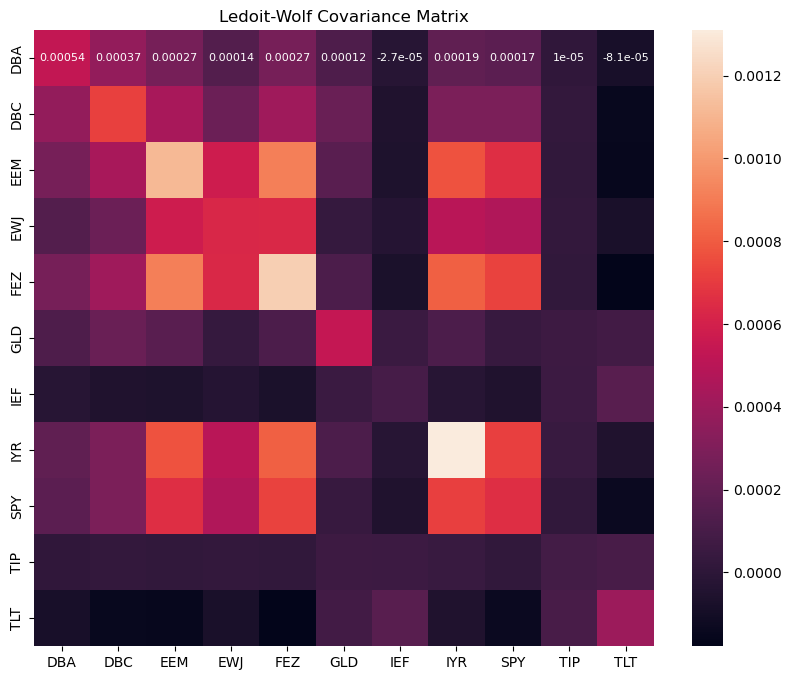

In [100]:
# Shrunk covariance matrix
lw_cov = cov_shrinkage(rets)

# Heatmap visualization of the shrunk covariance matrix
# Plot size = (10, 5)
# annot = True
# annot size = 8

plt.figure(figsize=(10, 8))
sns.heatmap(lw_cov, xticklabels=rets.columns, yticklabels=rets.columns, annot=True, annot_kws={"size": 8})
plt.title('Ledoit-Wolf Covariance Matrix')
plt.show()


- The heatmap displays the Ledoit-Wolf covariance matrix for a set of financial assets. The covariance matrix provides insights into the variance and covariances of asset returns. Higher values indicate a stronger relationship between the returns of two assets. For example, DBC and EEM have a covariance of 0.00046, suggesting a relatively strong relationship in their returns. Conversely, TLT and SPY show a negative covariance of -0.00015, indicating that their returns tend to move in opposite directions.
  

### 4. Hierarchical Risk Parity Portfolio

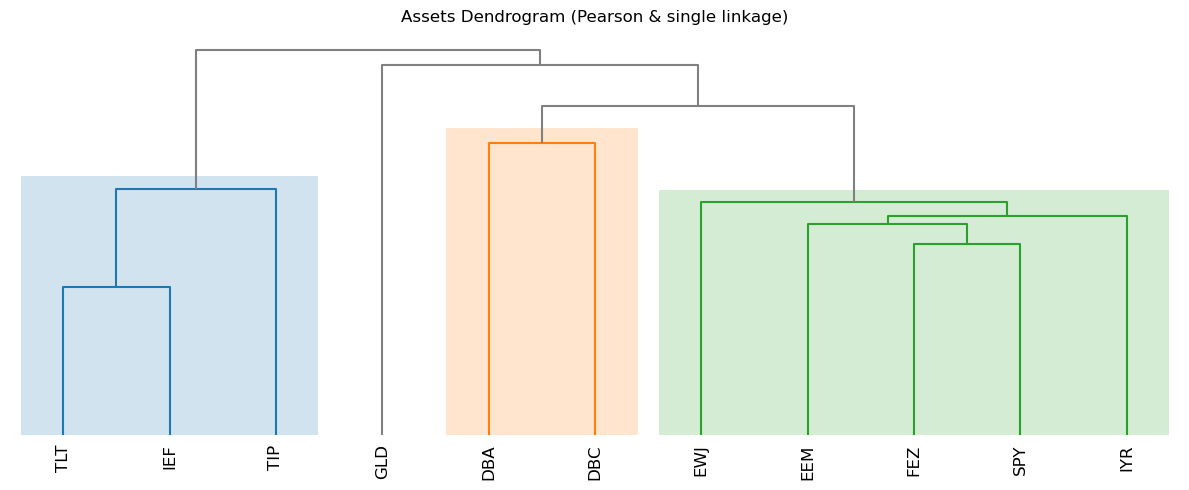

In [101]:
# Implementing Dendrogram


ax = rp.plot_dendrogram(returns=rets,
                        codependence='pearson',
                        linkage='single',
                        max_k=10,
                        leaf_order=True)

- The dendrogram illustrates the hierarchical clustering of financial assets based on their correlations using Pearson correlation and single linkage method. The assets are grouped together based on their similarities in returns. For example, TLT, IEF, and TIP form a cluster, indicating they have similar return characteristics. DBA and DBC form another distinct cluster. EWJ, EEM, FEZ, SPY, and IYR are grouped into a larger cluster, suggesting these assets have more similar return patterns compared to other groups.

In [102]:
# HRP object creation
port = rp.HCPortfolio(returns=rets)

# HRP weights calculation
w = port.optimization(model='HRP',
                      codependence='pearson',
                      rm='MV',
                      rf=0,
                      linkage='single',
                      max_k=10,
                      leaf_order=True)

w


,weights
DBA,0.050745
DBC,0.033733
EEM,0.012919
EWJ,0.023239
FEZ,0.017344
GLD,0.050331
IEF,0.283028
IYR,0.009150
SPY,0.018473
TIP,0.440423


- The displayed weights represent the allocation of a portfolio using the Hierarchical Risk Parity (HRP) optimization method. Each asset is assigned a specific weight indicating its proportion in the total portfolio. For instance, TIP has the highest allocation at 44.04%, suggesting a significant portion of the portfolio is invested in this asset. Conversely, IYR has the lowest allocation at 0.92%, indicating a smaller investment. These weights aim to balance the risk across the portfolio, ensuring diversification and stability.


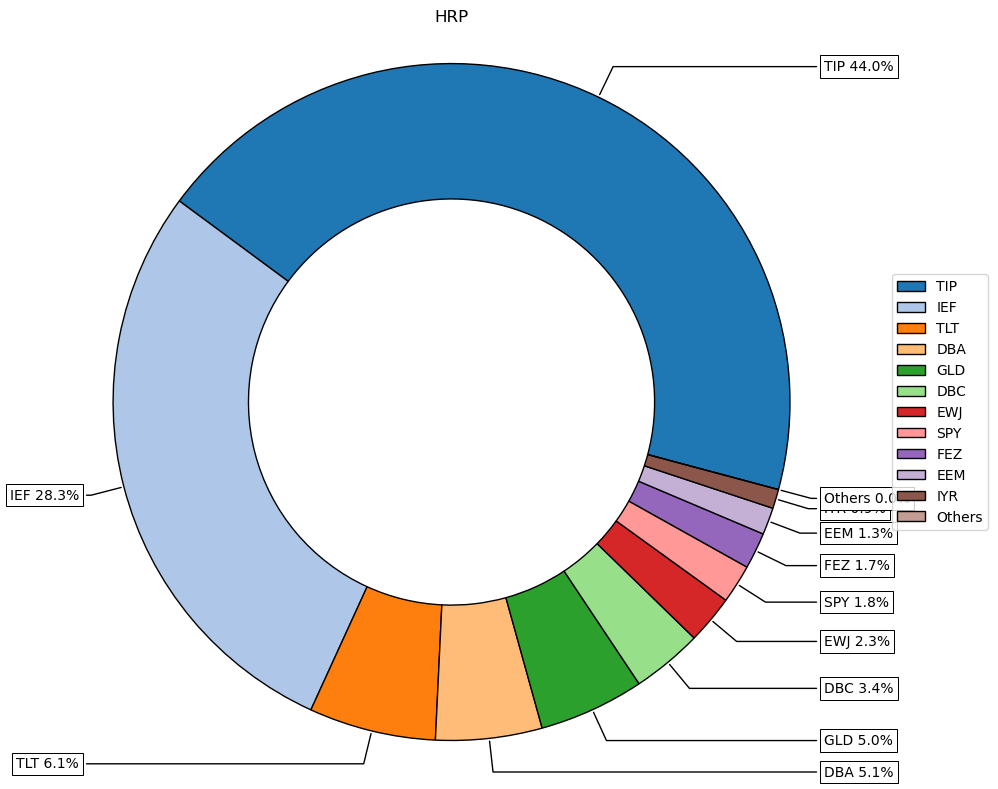

In [103]:
# Weight pie chart visualization
ax = rp.plot_pie(w=w,
                 title='HRP',
                 others=0.0,
                 #nrow=25,
                 cmap='tab20',
                 height=8,
                 width=10,
                 ax=None)

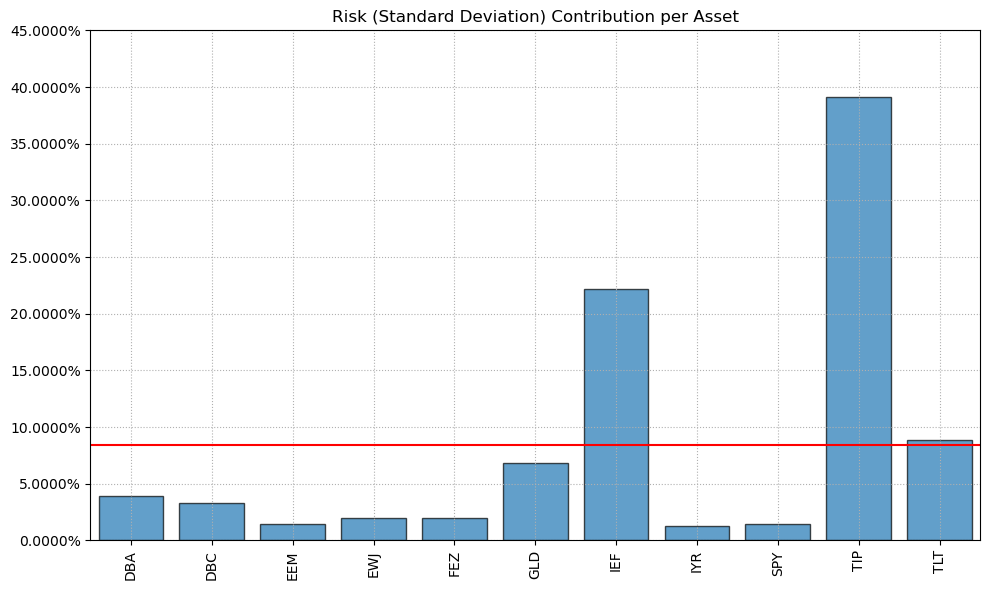

In [104]:
# Calculate mean returns and covariance matrix
mu = rets.mean() * 52
cov = rets.cov() * 52

# Calculate and visualize risk contributions
fig, ax = plt.subplots(figsize=(10, 6))
rp.plot_risk_con(w=w,
                 cov=cov,
                 returns=rets,
                 rm='MV',
                 rf=0,
                 alpha=0.05,
                 color="tab:blue",
                 t_factor=252,
                 ax=ax)
plt.show()

- The bar chart shows the risk contribution of each asset in the portfolio, measured by standard deviation. The blue bars represent the percentage contribution of each asset to the total portfolio risk. For instance, TIP contributes the most to the portfolio's risk with over 40%, while assets like EEM and EWJ contribute much less. The red line indicates the average risk contribution level. This visualization helps in understanding which assets are contributing the most to the overall portfolio risk, enabling better risk management and portfolio adjustment.

### 5. Implementing SRP and HRP Portfolio Backtesting Engine Class

In [105]:
class PortOptimPy:

    # Initialization function
    def __init__(self, price, param=52):

        # Annualization parameter
        self.param = param

        # Daily returns
        self.rets = price.pct_change().dropna()

    # Cross-sectional allocation model class
    class CrossSectional:

        # Shrinkage Risk Parity function (SRP)
        def srp(self, rets):

            # Covariance shrinkage function
            def cov_shrinkage(rets):
                lw = LedoitWolf()
                in_sample_lw = lw.fit(rets).covariance_
                return in_sample_lw

            # Equal risk contribution function
            def msd_risk(weights, target_risk, cov):
                port_var = weights.T @ cov @ weights
                marginal_contribs = cov @ weights
                risk_contribs = np.multiply(marginal_contribs, weights.T) / port_var
                w_contribs = risk_contribs
                return ((w_contribs - target_risk)**2).sum()

            noa = len(rets.columns)
            init_guess = np.repeat(1/noa, noa)
            bounds = ((0.0, 1.0), ) * noa
            target_risk = np.repeat(1/noa, noa)

            weights_sum_to_1 = {'type': 'eq',
                                'fun': lambda weights: np.sum(weights) - 1}

            weights = minimize(msd_risk,
                               init_guess,
                               args=(target_risk, cov_shrinkage(rets)),
                               method='SLSQP',
                               constraints=(weights_sum_to_1,),
                               bounds=bounds)

            return weights.x

        # Hierarchical Risk Parity function (HRP)
        def hrp(self, rets):

            # Create portfolio object
            port = rp.HCPortfolio(returns=rets)

            # Estimate optimal portfolio weights
            weights = port.optimization(model='HRP',
                                        codependence='pearson',
                                        rm='MV',
                                        rf=0,
                                        linkage='single',
                                        max_k=10,
                                        leaf_order=True)

            return np.array(weights.T).flatten()

    # Transaction cost function
    def transaction_cost(self, weights_df, rets_df, cost=0.001):

        # Previous period's investment weights
        prev_weights_df = (weights_df.shift(1).fillna(0) * (1 + rets_df.iloc[self.param-1:,:])) \
        .div((weights_df.shift(1).fillna(0) * (1 + rets_df.iloc[self.param-1:,:])).sum(axis=1), axis=0)

        # Transaction cost dataframe
        cost_df = abs(weights_df - prev_weights_df) * cost
        cost_df.fillna(0, inplace=True)

        return cost_df

    # Backtesting execution function
    def run(self, cs_model, cost=0.001):
        # Empty dictionary
        backtest_dict = {}

        # Daily returns dataframe
        rets = self.rets

        # Select and execute cross-sectional allocation model
        for i, index in enumerate(rets.index[self.param-1:]):
            if cs_model == 'SRP':
                backtest_dict[index] = self.CrossSectional().srp(rets.loc[:index])
            elif cs_model == 'HRP':
                backtest_dict[index] = self.CrossSectional().hrp(rets.loc[:index])

        # Cross-sectional weights dataframe
        cs_weights = pd.DataFrame(list(backtest_dict.values()), index=backtest_dict.keys(), columns=rets.columns)
        cs_weights.fillna(0, inplace=True)

        # Cross-sectional allocation model asset returns
        cs_rets = cs_weights.shift(1) * rets.iloc[self.param-1:,:]

        # Cross-sectional allocation model portfolio returns
        cs_port_rets = cs_rets.sum(axis=1)

        # Final portfolio investment weights
        port_weights = cs_weights.multiply(1, axis=0)

        # Transaction cost dataframe
        cost = self.transaction_cost(port_weights, rets)

        # Final portfolio asset returns
        port_asset_rets = port_weights.shift() * rets - cost

        # Final portfolio returns
        port_rets = port_asset_rets.sum(axis=1)
        port_rets.index = pd.to_datetime(port_rets.index).strftime("%Y-%m-%d")

        return port_weights, port_asset_rets, port_rets


### 6. Running the Backtesting Engine and Performance Analysis

In [106]:
# Initialize the engine
engine = PortOptimPy(df)

# Run backtest for SRP portfolio
srp_result = engine.run(cs_model='SRP')

# Run backtest for HRP portfolio
hrp_result = engine.run(cs_model='HRP')

# Extract SRP portfolio returns
srp_port_rets = srp_result[2]

# Extract HRP portfolio returns
hrp_port_rets = hrp_result[2]

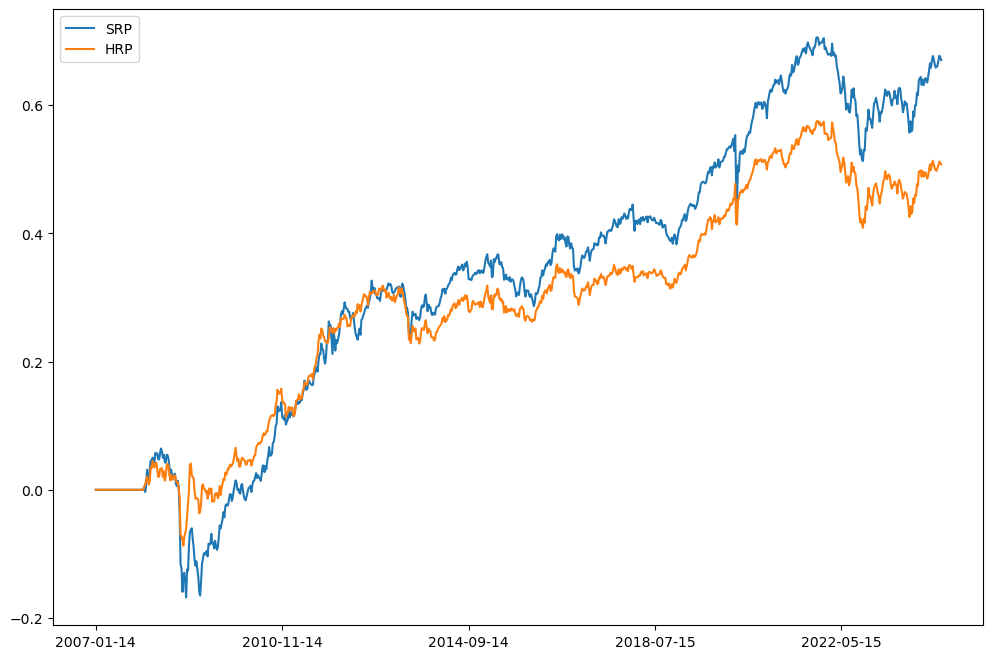

In [92]:
# Visualizing SRP and HRP Portfolio Backtesting Results
plt.figure(figsize=(12, 8))
srp_port_rets.cumsum().plot(label='SRP')
hrp_port_rets.cumsum().plot(label='HRP')
plt.legend()

The plot shows the cumulative returns of SRP (Shrinkage Risk Parity) and HRP (Hierarchical Risk Parity) portfolios over time. The blue line represents the SRP portfolio, and the orange line represents the HRP portfolio.

- SRP Portfolio: The SRP portfolio shows higher cumulative returns compared to the HRP portfolio throughout the period. This indicates that the SRP portfolio generally performed better in terms of returns.
- HRP Portfolio: The HRP portfolio, represented by the orange line, shows lower cumulative returns but might have lower volatility and different risk characteristics compared to the SRP portfolio.

The divergence between the two portfolios' performance can be attributed to the different methodologies used for risk parity and portfolio construction. The SRP method uses shrinkage techniques to adjust the covariance matrix, potentially leading to more aggressive allocation and higher returns. In contrast, the HRP method uses hierarchical clustering, which may result in more conservative allocations.

In [82]:
# Calculate Sharpe ratio for SRP portfolio
srp_sr = srp_port_rets.mean() * np.sqrt(52) / srp_port_rets.std()

# Calculate Sharpe ratio for HRP portfolio
hrp_sr = hrp_port_rets.mean() * np.sqrt(52) / hrp_port_rets.std()

# Print the results
print('SRP Sharpe Ratio: {}'.format(np.round(srp_sr, 2)))
print('HRP Sharpe Ratio: {}'.format(np.round(hrp_sr, 2)))

SRP Sharpe Ratio: 0.52
HRP Sharpe Ratio: 0.5


The calculated Sharpe Ratios for the SRP (Shrinkage Risk Parity) and HRP (Hierarchical Risk Parity) portfolios are 0.52 and 0.5, respectively.

- SRP Sharpe Ratio (0.52):

This indicates that the SRP portfolio has a risk-adjusted return of 0.52. It means that for every unit of risk taken, the SRP portfolio returns 0.52 units of return. This value suggests that the SRP portfolio performs slightly better in terms of risk-adjusted return compared to the HRP portfolio.

- HRP Sharpe Ratio (0.5):

This indicates that the HRP portfolio has a risk-adjusted return of 0.5. It means that for every unit of risk taken, the HRP portfolio returns 0.5 units of return. This value suggests that the HRP portfolio also performs well in terms of risk-adjusted return, but slightly less so compared to the SRP portfolio.

Overall, both portfolios have similar risk-adjusted returns, with the SRP portfolio having a marginally higher Sharpe Ratio, indicating a slightly better performance on a risk-adjusted basis.

### 7. Comparing SRP and HRP Portfolios with the Benchmark (SPY)

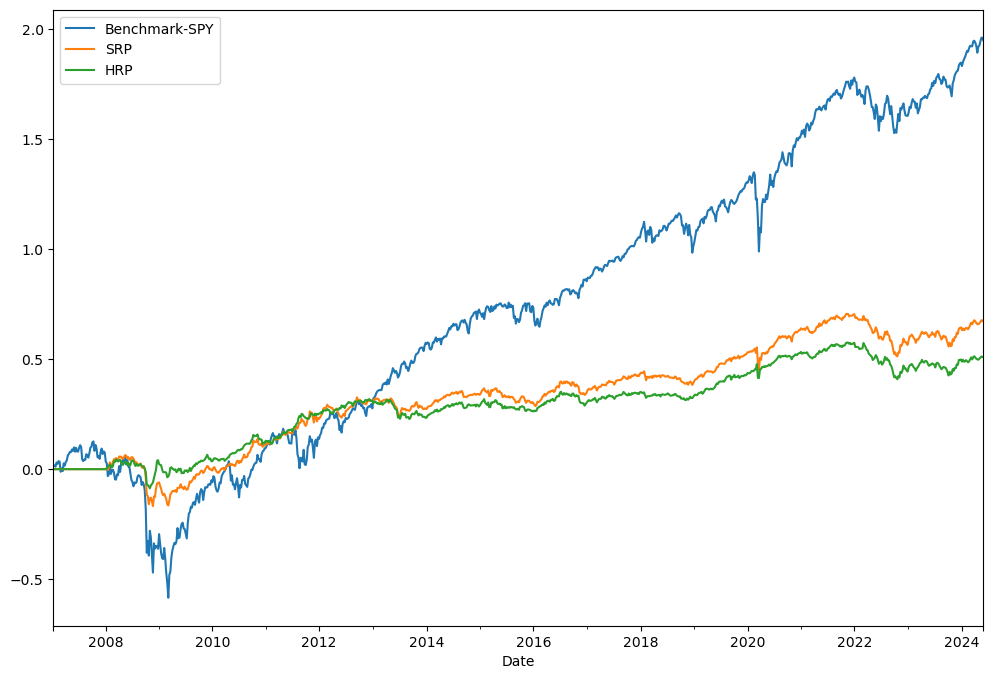

In [116]:
# Convert index to DatetimeIndex
rets.index = pd.to_datetime(rets.index)
srp_port_rets.index = pd.to_datetime(srp_port_rets.index)
hrp_port_rets.index = pd.to_datetime(hrp_port_rets.index)

# Plotting the graph
plt.figure(figsize=(12, 8))
rets['SPY'].cumsum().plot(label='Benchmark-SPY')
srp_port_rets.resample('W').last().cumsum().plot(label='SRP')
hrp_port_rets.resample('W').last().cumsum().plot(label='HRP')
plt.legend()
plt.show()

In [117]:
# Calculate Sharpe ratio for SRP portfolio
srp_sr = srp_port_rets.mean() * np.sqrt(52) / srp_port_rets.std()

# Calculate Sharpe ratio for HRP portfolio
hrp_sr = hrp_port_rets.mean() * np.sqrt(52) / hrp_port_rets.std()

# Calculate Sharpe ratio for SPY portfolio
spy_sr = rets['SPY'].mean() * np.sqrt(52) / rets['SPY'].std()

# Print the results
print('SRP Sharpe Ratio: {}'.format(np.round(srp_sr, 2)))
print('HRP Sharpe Ratio: {}'.format(np.round(hrp_sr, 2)))
print('SPY(Benchmark) Sharpe Ratio: {}'.format(np.round(spy_sr, 2)))

SRP Sharpe Ratio: 0.52
HRP Sharpe Ratio: 0.5
SPY(Benchmark) Sharpe Ratio: 0.6


### Return Rates & Sharp Ratio

1. SPY (S&P 500 ETF):
- Cumulative Returns: The SPY portfolio shows the highest cumulative returns, reaching approximately 2.0 by 2024. This indicates substantial growth, effectively doubling the investment over the period.
- Volatility: The SPY portfolio experienced significant volatility, particularly noticeable during the 2008-2009 financial crisis.
- Sharpe Ratio: 0.6, indicating a favorable risk-adjusted return, although it comes with higher volatility.

2. SRP (Shrinkage Risk Parity) Portfolio:
- Cumulative Returns: The SRP portfolio shows higher cumulative returns compared to the HRP portfolio, reaching around 0.75 by 2024.
- Volatility: The SRP portfolio exhibits lower volatility compared to SPY but higher than HRP.
- Sharpe Ratio: 0.52, reflecting a good balance between return and risk, making it suitable for investors seeking relatively high returns with moderate risk.

3. HRP (Hierarchical Risk Parity) Portfolio:
- Cumulative Returns: The HRP portfolio has cumulative returns of around 0.5 by 2024, showing the lowest returns among the three portfolios.
- Volatility: The HRP portfolio likely has the lowest volatility, offering more stable returns.
- Sharpe Ratio: 0.5, suggesting a risk-adjusted return comparable to SRP but with lower overall returns.

### Conclusion

In this analysis, we have evaluated the performance and risk-adjusted returns of the SPY, SRP (Shrinkage Risk Parity), and HRP (Hierarchical Risk Parity) portfolios over an extended period.

We demonstrated that both SRP and HRP portfolios, despite having lower absolute returns compared to the SPY, offer substantial benefits in terms of risk management and volatility reduction. The SRP portfolio showed higher cumulative returns than the HRP portfolio, but both SRP and HRP portfolios had favorable Sharpe ratios, indicating efficient risk-adjusted returns.

The SPY portfolio exhibited significant growth with high volatility, particularly during periods of market stress like the 2008-2009 financial crisis. In contrast, the SRP and HRP portfolios provided a more balanced approach, effectively mitigating risks while offering stable returns. The Sharpe ratios for SRP (0.52) and HRP (0.5) portfolios underscore their effectiveness in achieving a desirable balance between risk and return.

These findings suggest that SRP and HRP methodologies can be valuable tools for investors seeking to enhance portfolio stability and performance through advanced risk parity strategies. The use of shrinkage techniques in SRP and hierarchical clustering in HRP allows for strategic asset allocation that can withstand market volatilities and deliver consistent returns.

### Extension

To further enhance this analysis, several potential extensions can be explored:

1. Incorporating Advanced Risk Management Techniques:
- Implementing dynamic risk management strategies, such as time-varying volatility targeting, can further optimize the SRP and HRP portfolios' performance.
- Exploring the integration of machine learning algorithms to dynamically adjust the risk parity weights based on market conditions.

2. Exploring Alternative Asset Classes:
- Extending the SRP and HRP methodologies to include alternative asset classes such as commodities, real estate, or emerging markets can diversify the risk and potentially enhance returns.
- Assessing the impact of including non-correlated assets to improve the overall risk-return profile.

3. Optimization of Portfolio Construction Parameters:
- Fine-tuning the parameters used in shrinkage techniques for SRP to better capture the underlying market dynamics.
- Refining the hierarchical clustering methods in HRP to ensure optimal grouping of assets based on updated correlation structures.

4. Comparative Analysis with Other Risk Parity Approaches:
- Conducting a comparative study of SRP and HRP with other risk parity approaches, such as Equal Risk Contribution (ERC) or Minimum Variance Portfolio (MVP), to identify the most robust strategy under varying market conditions.

5. Application of Tail Risk Hedging Strategies:
- Implementing tail risk hedging strategies to protect the portfolios from extreme market downturns.
- Evaluating the effectiveness of options or futures contracts as hedging instruments within the SRP and HRP frameworks.

6. Long-Term Performance Analysis:
- Extending the performance analysis to a longer historical period to understand the behavior of SRP and HRP portfolios across different market cycles.
- Analyzing the portfolios' performance during major financial crises to validate their resilience and robustness.